# Vanilla ABC-SMC 
Set up requrirements and experimental data

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



# Define the ODE to solve 

We consider only recontamination from surface contacts, not from additional proliferation of the bacterias on the hands.
$$ y'=(1-y/C)r-d\exp(-g t)y$$

Currently we only consider the first 4 experimental datapoints as there is a gap which is hard to explain using this model-

In [2]:

def Distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum()


def ode_model(contamination,t,r,C,d,g):
    Contamination = contamination;
    return(r*(1-Contamination/C)-d*math.exp(-g*t)*Contamination)


def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 6
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["C"],parameters["d"],parameters["g"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
   # num_at_16=sim[int(precision*16/tmax)]
   # num_at_18=sim[int(precision*18/tmax)]
   # num_at_20=sim[int(precision*20/tmax)]
   # num_at_22=sim[int(precision*22/tmax)]
   # num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]+ sigma*np.random.randn(8)}
    return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# Define the parameter priors

We choose some examples to see how well it works.

In [3]:
parameter_prior = Distribution(r=RV("uniform", 0.0, 200.0),
                               C=RV("uniform", 1000.0, 6000.0),
                               d=RV("uniform", 10.0, 1000.0),
                               g=RV("uniform", 2.0, 200.0))

parameter_prior.get_parameter_names()

['C', 'd', 'g', 'r']

# Define the distance fuction
This currently is a vanilla absolute distances between the two points.

In [4]:
def distance(simulation, data):
    return np.absolute(data["Contamination"] - simulation["Contamination"]).sum()

# Set up the ABC SMC 


In [5]:
#sigma=0.02
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)
#eps = pyabc.Temperature()

#abc = pyabc.ABCSMC(deterministic_run, parameter_prior, kernel, eps=eps, acceptor=acceptor,population_size=1000)
#abc.new(db_path,{"Contamination": measurement_data}) #This distance model assumes the name of the predicited and confirmed are the same
#history_acceptor = abc.run(max_nr_populations=5,minimum_epsilon=50000)

In [6]:
# We plug all the ABC options together
abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=500,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(50000, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


# Setting the observed data

In [7]:
# y_observed is the important piece here: our actual observation.
initial_contamination=1200.0
measurement_data = np.array([134.0,202.0,294.0]) #,400,644,1232,2044,2868
s=np.array([93.70165,86.13942,162.11107,116.61904,123.61230,396.88789,628.87201,1147.13556])
precision=5000
measurement_times = np.array([2,4,6])#np.arange(len(measurement_data))  
# and we define where to store the results

history = abc.new(db_path, {"Contamination": measurement_data})

ABC.History INFO: Start <ABCSMC id=3, start_time=2022-03-15 20:46:01>


# Running the ABC

In [8]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=500, max_nr_populations=5)

ABC INFO: t: 0, eps: 5.00000000e+04.
ABC INFO: Accepted: 500 / 507 = 9.8619e-01, ESS: 5.0000e+02.
ABC INFO: t: 1, eps: 1.55083755e+03.
ABC INFO: Accepted: 500 / 1297 = 3.8551e-01, ESS: 4.3030e+02.
ABC INFO: t: 2, eps: 6.94144470e+02.
ABC INFO: Accepted: 500 / 10242 = 4.8819e-02, ESS: 4.2205e+02.
ABC INFO: t: 3, eps: 4.37819007e+02.
ABC.History INFO: Done <ABCSMC id=3, duration=1:21:59.516360, end_time=2022-03-15 22:08:00>


KeyboardInterrupt: 

# Plot simulated trajectories
Simulated trajectories plotted against observed experimental data

In [ ]:
true_trajectory = ode_model({"Contamination": theta1_true, "theta2": theta2_true})["X_2"]

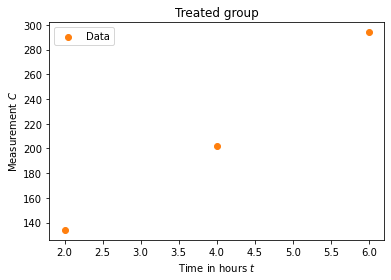

In [13]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Contamination'], color='grey', alpha=0.1)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Contamination'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


#ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time in hours $t$')
plt.ylabel('Measurement $C$')
plt.title('Treated group')
plt.legend()
plt.show()

# Visualise the probability density functions


In [12]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "theta1",
        "theta2",
        xmin=0,
        xmax=1,
        numx=200,
        ymin=0,
        ymax=1,
        numy=200,
        ax=ax,
    )

    ax.legend()
fig.tight_layout()

NameError: name 'h' is not defined

<Figure size 720x576 with 0 Axes>